# Transform segmentation masks

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.color import hsv2rgb

from tifffile import imread

from __future__ import print_function

In [2]:
import sys
sys.path.insert(0, r"D:\Masters_Medical_Informatics_Larger_Files\Thesis\Working_Folder\pckg_stainwarpy\stainwarpy")

In [3]:
import importlib, stainwarpy
importlib.reload(stainwarpy)
importlib.reload(stainwarpy.reg)
importlib.reload(stainwarpy.metrics)
importlib.reload(stainwarpy.regPipeline)
importlib.reload(stainwarpy.preprocess)

<module 'stainwarpy.preprocess' from 'D:\\Masters_Medical_Informatics_Larger_Files\\Thesis\\Working_Folder\\pckg_stainwarpy\\stainwarpy\\stainwarpy\\preprocess.py'>

In [4]:
def load_image_data(folder_path):

    img_data = []
    label_data = []
    
    for _, _, files in os.walk(folder_path):
        for index, file in enumerate(files):
            if file.endswith(".tif"): 
                image_path = os.path.join(folder_path, file)
                img_raw = imread(image_path)
                img = np.array(img_raw)
                img_data.append(img)

    return img_data

In [ ]:
hne_px_sz = 0.5023
dapi_px_sz = 0.209877

scale = hne_px_sz / dapi_px_sz

# load dapi
dapi_img_data = load_image_data("../../../Thesis_Data/for_testing/CRC027/cropped/dapi")
dapi1_init = resize(dapi_img_data[0], (int(dapi_img_data[0].shape[0]/scale), int(dapi_img_data[0].shape[1]/scale)), anti_aliasing=True)
dapi2_init = resize(dapi_img_data[1], (int(dapi_img_data[1].shape[0]/scale), int(dapi_img_data[1].shape[1]/scale)), anti_aliasing=True)
dapi1_init, dapi2_init = dapi1_init*255, dapi2_init*255

# load hne
hne_image_data = load_image_data("../../../Thesis_Data/for_testing/CRC027/cropped/hne")
hne1_init = hne_image_data[0]
hne2_init = hne_image_data[1]

hne1_deconv = stainwarpy.colour_deconvolusion_preprocessing_HnE(hne1_init)
hne2_deconv = stainwarpy.colour_deconvolusion_preprocessing_HnE(hne2_init)

In [6]:
# display masks
def masks_to_rgb_white_bg(masks, colors=None):
    H, W = masks.shape
    HSV = np.zeros((H, W, 3), dtype=np.float32)

    num_instances = masks.max()

    if colors is None:
        hues = np.linspace(0, 1, num_instances + 1)[np.random.permutation(num_instances)]
    else:
        hues = colors[:, 0]

    for n in range(1, num_instances + 1):
        ipix = np.where(masks == n)
        HSV[ipix[0], ipix[1], 0] = hues[n - 1]   # hue
        HSV[ipix[0], ipix[1], 1] = 1.0           # saturation
        HSV[ipix[0], ipix[1], 2] = 1.0           # value

    RGB = (hsv2rgb(HSV) * 255).astype(np.uint8)

    bg = (masks == 0)
    RGB[bg] = np.array([255, 255, 255], dtype=np.uint8)

    return RGB

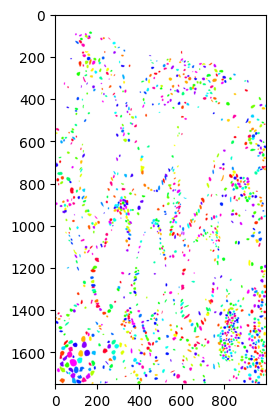

In [7]:
# load masks
masks = np.load("../../../Thesis_Data/for_testing/CRC027/cropped/hne_cropped_1_seg_masks.npy")
rbg = masks_to_rgb_white_bg(masks)
plt.imshow(rbg)

In [8]:
# overlay mask on image
def overlay_mask_on_image(image, seg_rgb, alpha=0.5):

    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)

    img = image.astype(np.float32)
    if img.max() > 1:
        img /= 255.

    mask = seg_rgb.astype(np.float32) / 255.

    blended = (1 - alpha) * img + alpha * mask
    return blended

def plot_before_after_overlay(
        image_before, mask_rgb_before,
        image_after, mask_rgb_after,
        alpha=0.5
    ):

    overlay_before = overlay_mask_on_image(image_before, mask_rgb_before, alpha)
    overlay_after  = overlay_mask_on_image(image_after,  mask_rgb_after,  alpha)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.title("Before Transformation")
    plt.imshow(overlay_before)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("After Transformation")
    plt.imshow(overlay_after)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

### Register images and display transformed masks

In [ ]:
# similarity transform
transformation_maps, moved_img, tre, mi = stainwarpy.registration_pipeline("../../../Thesis_Data/for_testing/CRC027/cropped/dapi/dapi_cropped_1.tif", 
                                                                                   "../../../Thesis_Data/for_testing/CRC027/cropped/hne/hne_cropped_1.tif", 0.209877, 0.5023, 
                                                                                   fixed_img='multiplexed')

Images loaded.
Preprocessing completed.
Feature based registration completed.
rTRE before registration:  0.06770937735100896
rTRE after feature based registration:  0.001017369139757124
normalized MI before registration:  0.0024897097794239183
normalized MI after feature based registration:  0.05884405828120605


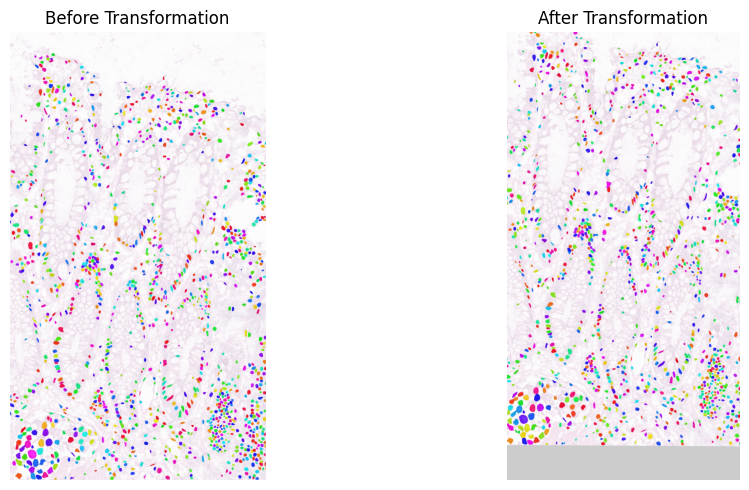

In [ ]:
# transform mask
moved_mask = stainwarpy.transform_seg_mask(masks, transformation_maps, output_shape=dapi1_init.shape)
rbg_moved = masks_to_rgb_white_bg(moved_mask)
plot_before_after_overlay(
    image_before=hne1_init,
    mask_rgb_before=rbg,
    image_after=moved_img,
    mask_rgb_after=rbg_moved,
    alpha=0.8
)


In [ ]:
# projective transform
transformation_maps, moved_img, tre, mi = stainwarpy.registration_pipeline("../../../Thesis_Data/for_testing/CRC027/cropped/dapi/dapi_cropped_1.tif", 
                                                                                   "../../../Thesis_Data/for_testing/CRC027/cropped/hne/hne_cropped_1.tif", 0.209877, 0.5023, 
                                                                                   fixed_img='multiplexed', feature_tform='projective')

Images loaded.
Preprocessing completed.
Feature based registration completed.
rTRE before registration:  0.06864897863786627
rTRE after feature based registration:  0.0031665467212970947
normalized MI before registration:  0.0024897097794239183
normalized MI after feature based registration:  0.024813186221606894


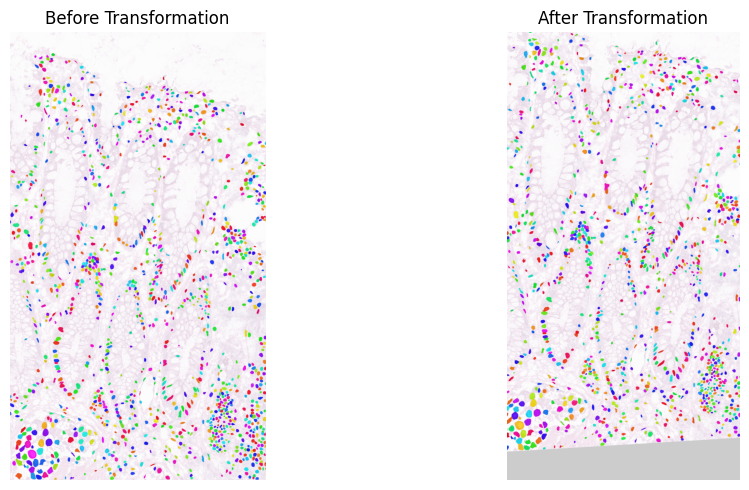

In [ ]:
# transform mask
moved_mask = stainwarpy.transform_seg_mask(masks, transformation_maps, output_shape=dapi1_init.shape)
rbg_moved = masks_to_rgb_white_bg(moved_mask)
plot_before_after_overlay(
    image_before=hne1_init,
    mask_rgb_before=rbg,
    image_after=moved_img,
    mask_rgb_after=rbg_moved,
    alpha=0.8
)

In [ ]:
###### for cli

# python -m stainwarpy.stainwarpy.reg_cli transform-seg-mask ../Thesis_Data/for_testing/CRC027/cropped/hne_cropped_1_seg_masks.npy ../Thesis_Data/for_testing/CRC027/cropped/dapi/dapi_cropped_1.tif ../Thesis_Data ../Thesis_Data/results/feature_based_transformation_map.npy 0.5023 --fixed-px-sz 0.209877